In [ ]:
import json
import sys
from pathlib import Path
import cv2

src_path = Path.cwd().parent
sys.path.append(str(src_path))

from src.config import config
from src.dto import Dto


def load_image_json_data(filename: str) -> Dto:
    try:
        with open(filename, "r") as file:
            data = json.load(file)
        return Dto(**data)
    except Exception as e:
        print(f"Failed to load JSON data from {filename}: {e}")
        return None

json_files_directory:str = config.output_path
json_files = [f for f in Path(json_files_directory).rglob("*.json")]
print(f"Found {len(json_files)} JSON files in {json_files_directory}")

data = []
for file in json_files:
    dto = load_image_json_data(file)
    if dto is not None:
        data.append(dto)
print(f"Loaded {len(data)} DTOs")


Config: {'cores': 1, 'dataset_path': 'C:/Users/Vectro/.cache/kagglehub/datasets/felicepollano/watermarked-not-watermarked-images/versions/1/wm-nowm/train/no-watermark', 'output_path': 'D:\\Data\\Python\\proj_badawczy_2024_adam', 'default_watermark': 'test', 'logger': <Logger.NO: 'NO'>, 'device': 'cuda'}
Found 100 JSON files in D:\Data\Python\proj_badawczy_2024_adam
Loaded 100 DTOs


C:\Users\Vectro\AppData\Local\Temp\ipykernel_35760\1956389196.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(encoding_times.values(), labels=encoding_times.keys())


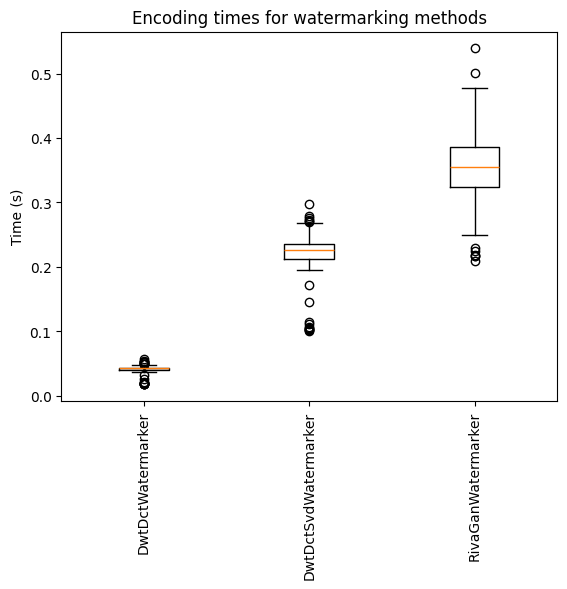

C:\Users\Vectro\AppData\Local\Temp\ipykernel_35760\1956389196.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(decoding_times.values(), labels=decoding_times.keys())


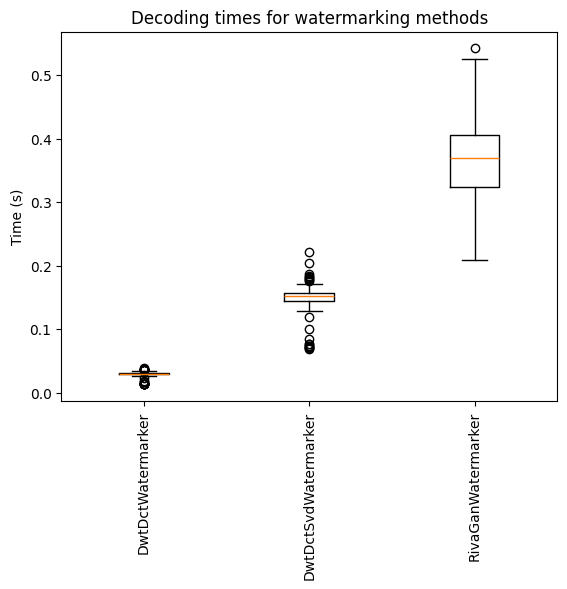

C:\Users\Vectro\AppData\Local\Temp\ipykernel_35760\1956389196.py:106: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(ber.values(), labels=ber.keys())


Failed to load BER for 365 attacks


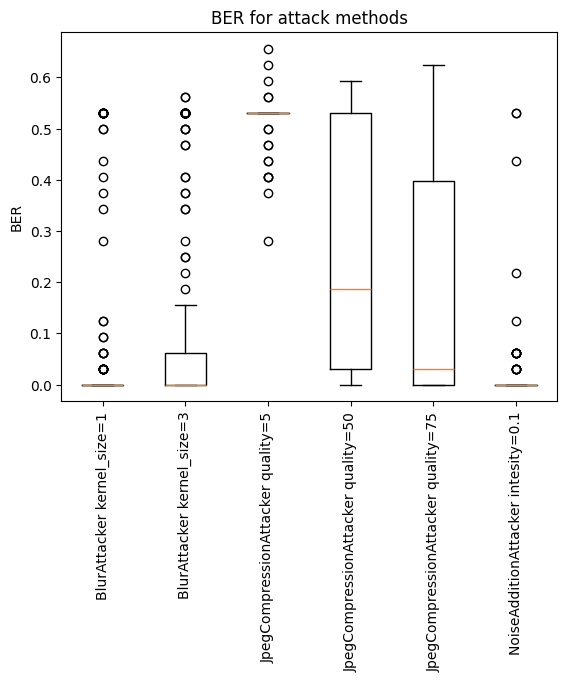

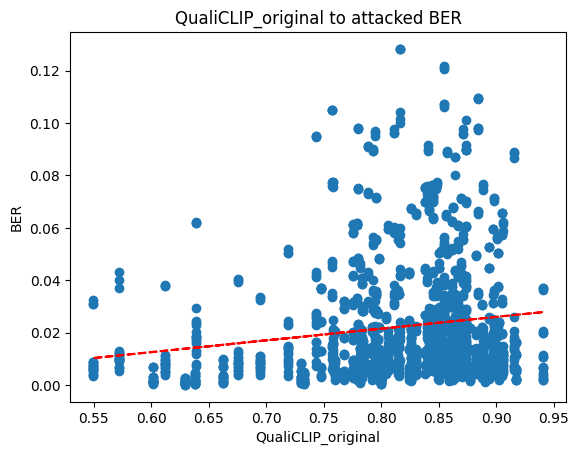

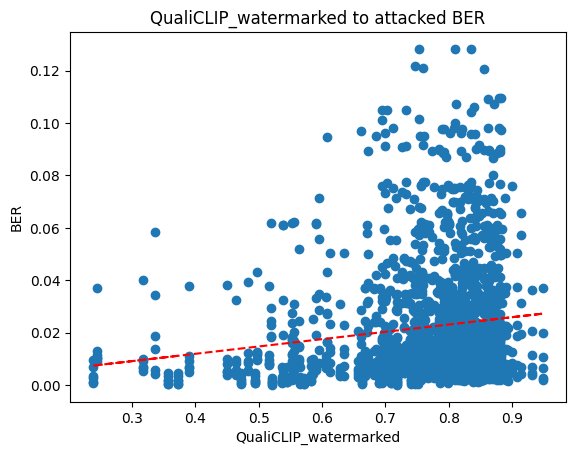

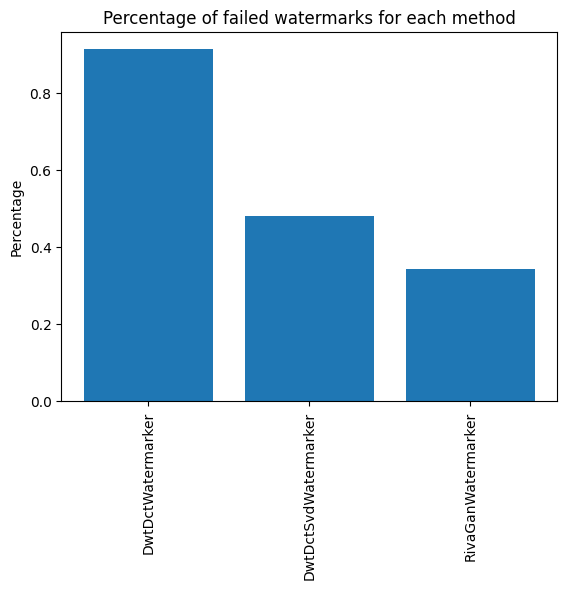

C:\Users\Vectro\AppData\Local\Temp\ipykernel_35760\1956389196.py:194: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(ber.values(), labels=ber.keys())


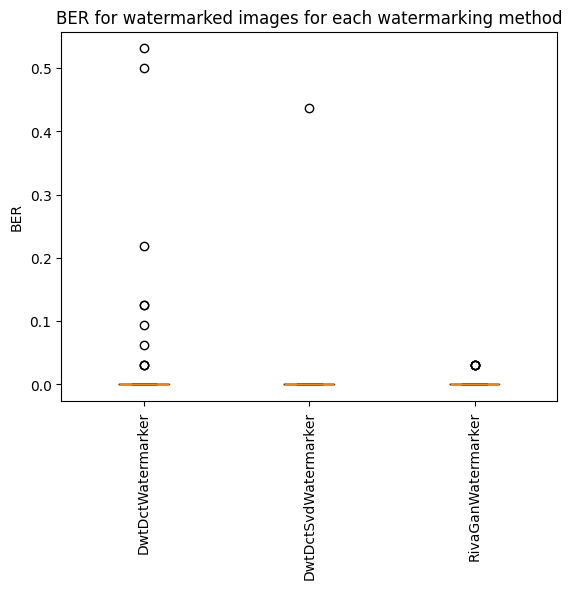

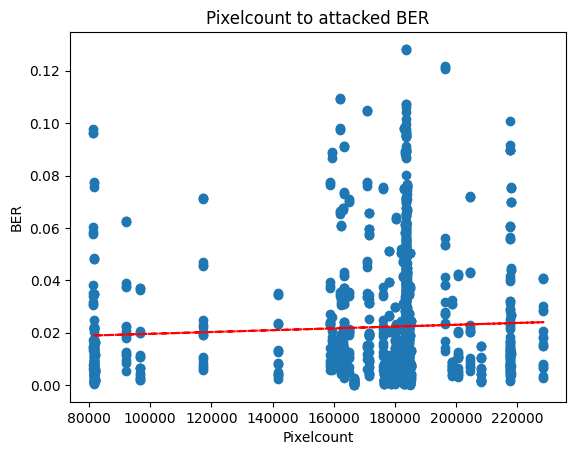

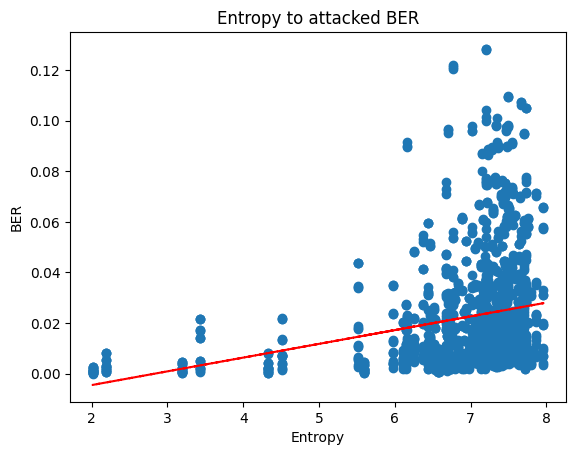

In [30]:
'''
class ImageMetricsModel(BaseModel):
    PSNR: float
    SSIM_RGB: float
    SSIM_Greyscale: float
    Bit_Error_Rate: float
    Mean_Squared_Error: float
    Entropy: float
    Average_Pixel_Error: float
    QualiCLIP_original: float
    QualiCLIP_watermarked: float
    LPIPS_Loss: float | None


class DtoLog(BaseModel):
    filepath: str
    watermarked_analysis_results: ImageMetricsModel
    watermark_method: str
    attack_method: str
    encoding_time: float
    decoding_time: float


class DecodingMetricsModel(BaseModel):
    Correlation_Coefficient: float | None
    Normalized_Correlation_Coefficient: float | None
    Bit_Error_Rate: float
    Mean_Squared_Error: float


class DtoDecode(BaseModel):
    decoded_watermark: str | None  # TODO change to bytes?
    decoding_time: float | None
    decoding_metrics: DecodingMetricsModel | None


class DtoAttack(BaseModel):
    name: str
    attacking_time: float | None
    decoding_results: DtoDecode
    analysis_results: ImageMetricsModel | None


class DtoWatermark(BaseModel):
    name: str
    encoding_time: float
    decoding_results: DtoDecode
    analysis_results: ImageMetricsModel | None
    attacks: list[DtoAttack] = []


class Dto(BaseModel):
    filepath: str
    watermark: str
    watermarks: list[DtoWatermark] = []

'''

# plot encoding times for each watermarking method
import matplotlib.pyplot as plt
import numpy as np

watermarking_methods = set()
encoding_times = {}
for dto in data:
    for watermark in dto.watermarks:
        watermarking_methods.add(watermark.name)
        encoding_times[watermark.name] = encoding_times.get(watermark.name, []) + [watermark.encoding_time]

fig, ax = plt.subplots()
ax.boxplot(encoding_times.values(), labels=encoding_times.keys())
ax.set_title("Encoding times for watermarking methods")
ax.set_ylabel("Time (s)")
plt.xticks(rotation=90)
plt.show()

# plot decoding times for each watermarking method
decoding_times = {}
for dto in data:
    for watermark in dto.watermarks:
        decoding_times[watermark.name] = decoding_times.get(watermark.name, []) + [watermark.decoding_results.decoding_time]

fig, ax = plt.subplots()
ax.boxplot(decoding_times.values(), labels=decoding_times.keys())
ax.set_title("Decoding times for watermarking methods")
ax.set_ylabel("Time (s)")
plt.xticks(rotation=90)
plt.show()

# plot ber of each attack method
attack_methods = set()
ber = {}
failed = 0
for dto in data:
    for watermark in dto.watermarks:
        for attack in watermark.attacks:
            attack_methods.add(attack.name)
            try:
                ber[attack.name] = ber.get(attack.name, []) + [attack.decoding_results.decoding_metrics.Bit_Error_Rate]
            except:
                failed += 1
                pass
print(f"Failed to load BER for {failed} attacks")

fig, ax = plt.subplots()
ax.boxplot(ber.values(), labels=ber.keys())
ax.set_title("BER for attack methods")
ax.set_ylabel("BER")
plt.xticks(rotation=90)
plt.show()

# plot QualiCLIP_original to attacked BER
qualiclip_original = []
ber_attacked = []
for dto in data:
    for watermark in dto.watermarks:
        for attack in watermark.attacks:
            try:
                x = watermark.analysis_results.QualiCLIP_original
                y = attack.analysis_results.Bit_Error_Rate
                qualiclip_original.append(x)
                ber_attacked.append(y)
            except:
                pass

fig, ax = plt.subplots()
ax.scatter(qualiclip_original, ber_attacked)
ax.set_title("QualiCLIP_original to attacked BER")
ax.set_xlabel("QualiCLIP_original")
ax.set_ylabel("BER")
# add trendline
z = np.polyfit(qualiclip_original, ber_attacked, 1)
p = np.poly1d(z)
plt.plot(qualiclip_original, p(qualiclip_original), "r--")
plt.show()


# plot QualiCLIP_watermarked to attacked BER
qualiclip_watermarked = []
ber_attacked = []
for dto in data:
    for watermark in dto.watermarks:
        for attack in watermark.attacks:
            try:
                x = watermark.analysis_results.QualiCLIP_watermarked
                y = attack.analysis_results.Bit_Error_Rate
                qualiclip_watermarked.append(x)
                ber_attacked.append(y)
            except:
                pass

fig, ax = plt.subplots()
ax.scatter(qualiclip_watermarked, ber_attacked)
ax.set_title("QualiCLIP_watermarked to attacked BER")
ax.set_xlabel("QualiCLIP_watermarked")
ax.set_ylabel("BER")
# add trendline
z = np.polyfit(qualiclip_watermarked, ber_attacked, 1)
p = np.poly1d(z)
plt.plot(qualiclip_watermarked, p(qualiclip_watermarked), "r--")
plt.show()

# draw table of percantage of failed watermarks for each methods (watermark isnt equal to decoded watermark)
# variable data.dto.watermarks.decoding_results.decoded_watermark vs data.dto.watermark
failed_watermarks = {}
total_watermarks = {}
for dto in data:
    for watermark in dto.watermarks:
        for attack in watermark.attacks:
            if dto.watermark != attack.decoding_results.decoded_watermark:
                failed_watermarks[watermark.name] = failed_watermarks.get(watermark.name, 0) + 1
            total_watermarks[watermark.name] = total_watermarks.get(watermark.name, 0) + 1

for key in total_watermarks.keys():
    failed_watermarks[key] = failed_watermarks.get(key, 0) / total_watermarks[key]

fig, ax = plt.subplots()
ax.bar(failed_watermarks.keys(), failed_watermarks.values())
ax.set_title("Percentage of failed watermarks for each method")
ax.set_ylabel("Percentage")
plt.xticks(rotation=90)
plt.show()

# plot watermarked image decoded BER for each watermarking method
ber = {}
for dto in data:
    for watermark in dto.watermarks:
        try:
            ber[watermark.name] = ber.get(watermark.name, []) + [watermark.decoding_results.decoding_metrics.Bit_Error_Rate]
        except:
            pass

fig, ax = plt.subplots()
ax.boxplot(ber.values(), labels=ber.keys())
ax.set_title("BER for watermarked images for each watermarking method")
ax.set_ylabel("BER")
plt.xticks(rotation=90)
plt.show()


# plot pixelcount to attacked decoded BER, pixelcounts needs to be calculated from image data get_image_data(filename)
pixelcount = []
ber_attacked = []
failed, total = 0, 0
for dto in data:
    for watermark in dto.watermarks:
        for attack in watermark.attacks:
            total += 1
            try:
                img = cv2.imread(dto.filepath)
                x = img.shape[0] * img.shape[1]
                y = attack.analysis_results.Bit_Error_Rate
                pixelcount.append(x)
                ber_attacked.append(y)
            except:
                failed += 1
                pass
if failed/total > 0.1:
    print(f"Failed to load BER for {failed} attacks ({failed/total:.2%})")

fig, ax = plt.subplots()
ax.scatter(pixelcount, ber_attacked)
ax.set_title("Pixelcount to attacked BER")
ax.set_xlabel("Pixelcount")
ax.set_ylabel("BER")
# add trendline
z = np.polyfit(pixelcount, ber_attacked, 1)
p = np.poly1d(z)
plt.plot(pixelcount, p(pixelcount), "r--")
plt.show()

# plot image entropy to attacked decoded BER
entropy = []
ber_attacked = []
failed, total = 0, 0
for dto in data:
    for watermark in dto.watermarks:
        for attack in watermark.attacks:
            total += 1
            try:
                img = cv2.imread(dto.filepath)
                x = cv2.calcHist([img], [0], None, [256], [0, 256])
                x = -np.sum(x[x > 0] / np.sum(x) * np.log2(x[x > 0] / np.sum(x)))
                y = attack.analysis_results.Bit_Error_Rate
                entropy.append(x)
                ber_attacked.append(y)
            except:
                failed += 1
                pass
if failed/total > 0.1:
    print(f"Failed to load BER for {failed} attacks ({failed/total:.2%})")

fig, ax = plt.subplots()
ax.scatter(entropy, ber_attacked)
ax.set_title("Entropy to attacked BER")
ax.set_xlabel("Entropy")
ax.set_ylabel("BER")
# add trendline
z = np.polyfit(entropy, ber_attacked, 1)
p = np.poly1d(z)
plt.plot(entropy, p(entropy), "r--")
plt.show()








C:\Users\Vectro\AppData\Local\Temp\ipykernel_35760\2085738553.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(psnr.values(), labels=psnr.keys())


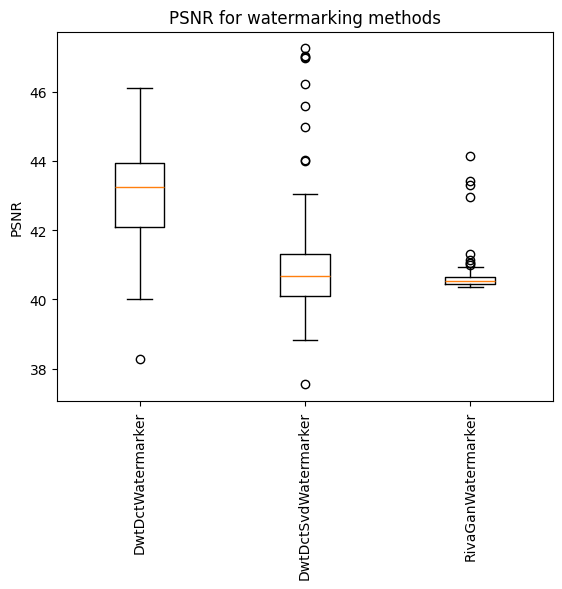

In [36]:
# plot watermark method to PSNR
psnr = {}
total = 0
for dto in data:
    for watermark in dto.watermarks:
        psnr[watermark.name] = psnr.get(watermark.name, []) + [watermark.analysis_results.PSNR]
        total += 1

fig, ax = plt.subplots()
ax.boxplot(psnr.values(), labels=psnr.keys())
ax.set_title(f"PSNR for watermarking methods")
ax.set_ylabel("PSNR")
plt.xticks(rotation=90)
plt.show()

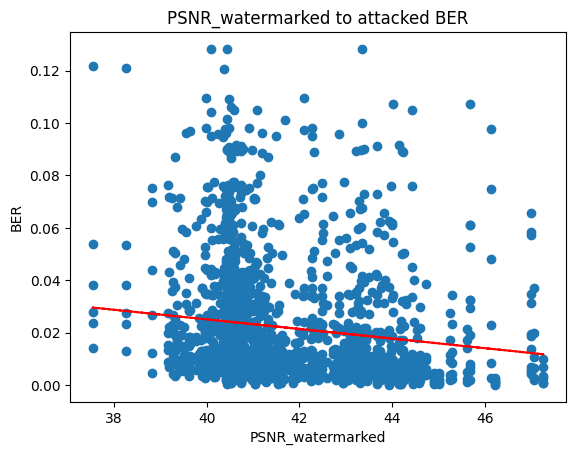

In [37]:
# watermarked PSNR to attacked BER
psnr_watermarked = []
ber_attacked = []
failed, total = 0, 0
for dto in data:
    for watermark in dto.watermarks:
        for attack in watermark.attacks:
            total += 1
            try:
                x = watermark.analysis_results.PSNR
                y = attack.analysis_results.Bit_Error_Rate
                psnr_watermarked.append(x)
                ber_attacked.append(y)
            except:
                failed += 1
                pass
if failed/total > 0.1:
    print(f"Failed to load BER for {failed} attacks ({failed/total:.2%})")

fig, ax = plt.subplots()
ax.scatter(psnr_watermarked, ber_attacked)
ax.set_title("PSNR_watermarked to attacked BER")
ax.set_xlabel("PSNR_watermarked")
ax.set_ylabel("BER")
# add trendline
z = np.polyfit(psnr_watermarked, ber_attacked, 1)
p = np.poly1d(z)
plt.plot(psnr_watermarked, p(psnr_watermarked), "r--")
plt.show()


C:\Users\Vectro\AppData\Local\Temp\ipykernel_35760\121433777.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(ssim.values(), labels=ssim.keys())


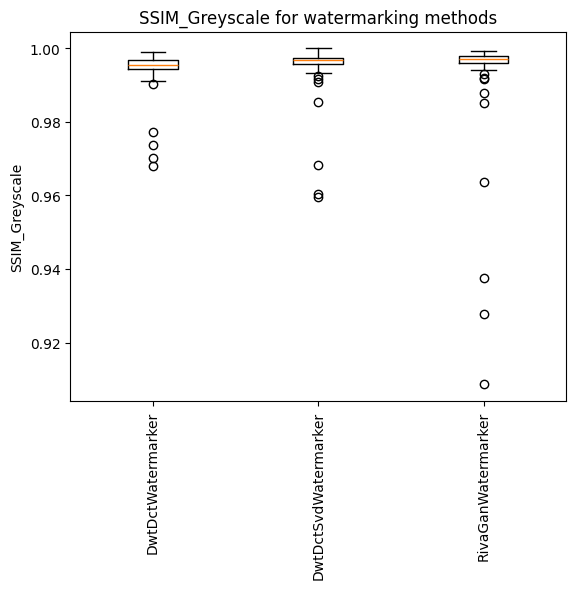

In [38]:
# plot watermark method to SSIM_Greyscale
ssim = {}
total = 0
for dto in data:
    for watermark in dto.watermarks:
        ssim[watermark.name] = ssim.get(watermark.name, []) + [watermark.analysis_results.SSIM_Greyscale]
        total += 1

fig, ax = plt.subplots()
ax.boxplot(ssim.values(), labels=ssim.keys())
ax.set_title(f"SSIM_Greyscale for watermarking methods")
ax.set_ylabel("SSIM_Greyscale")
plt.xticks(rotation=90)
plt.show()


C:\Users\Vectro\AppData\Local\Temp\ipykernel_35760\3579973616.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(ssim.values(), labels=ssim.keys())


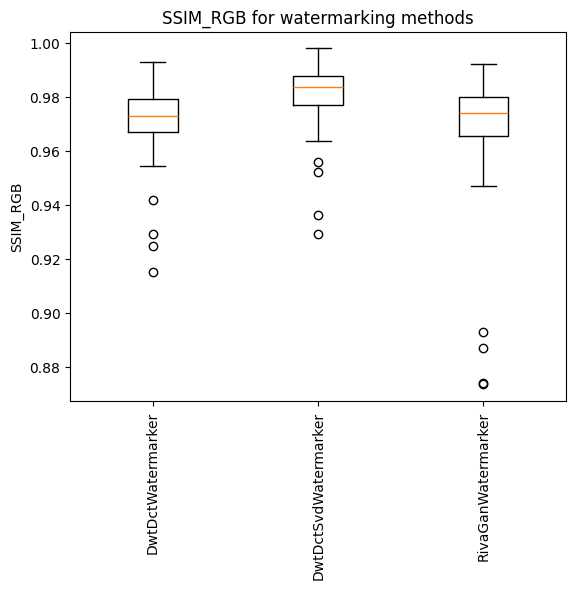

In [ ]:
# plot watermark method to SSIM_RGB
ssim = {}
total = 0
for dto in data:
    for watermark in dto.watermarks:
        ssim[watermark.name] = ssim.get(watermark.name, []) + [watermark.analysis_results.SSIM_RGB]
        total += 1

fig, ax = plt.subplots()
ax.boxplot(ssim.values(), labels=ssim.keys())
ax.set_title(f"SSIM_RGB for watermarking methods")
ax.set_ylabel("SSIM_RGB")
plt.xticks(rotation=90)
plt.show()


C:\Users\Vectro\AppData\Local\Temp\ipykernel_35760\262727133.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(mse.values(), labels=mse.keys())


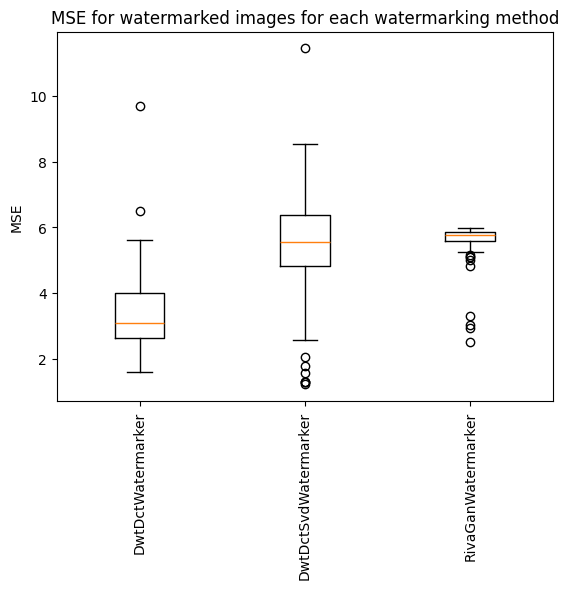

In [ ]:
mse = {}
total = 0
for dto in data:
    for watermark in dto.watermarks:
        mse[watermark.name] = mse.get(watermark.name, []) + [watermark.analysis_results.Mean_Squared_Error]
        total += 1

fig, ax = plt.subplots()
ax.boxplot(mse.values(), labels=mse.keys())
ax.set_title(f"MSE for watermarked images for each watermarking method")
ax.set_ylabel("MSE")
plt.xticks(rotation=90)
plt.show()


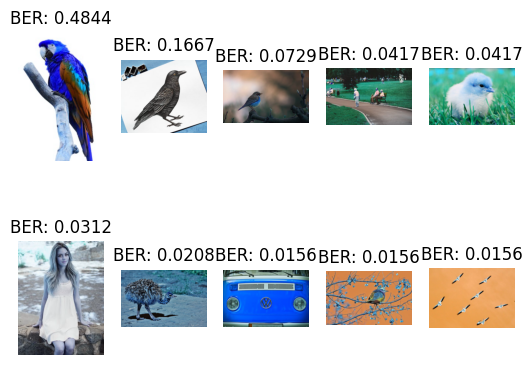

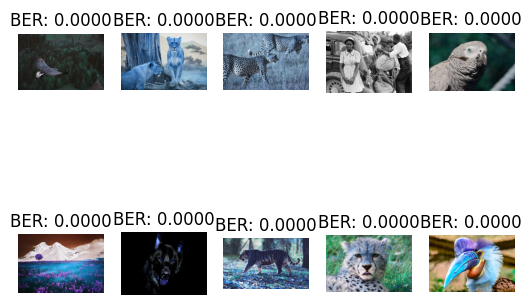

In [50]:
# sort images by highest to lowest averaged! watermarked encoded BER
images = {} # key: image path, value: list of BERs
for dto in data:
    ber = []
    for watermark in dto.watermarks:
        try:
            ber.append(watermark.decoding_results.decoding_metrics.Bit_Error_Rate)
        except:
            pass
    if ber:
        images[dto.filepath] = np.mean(ber)

sorted_images = {k: v for k, v in sorted(images.items(), key=lambda item: item[1], reverse=True)}
# draw images on plot, top 10
fig, ax = plt.subplots(2, 5)
for i, (k, v) in enumerate(sorted_images.items()):
    img = cv2.imread(k)
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].set_title(f"BER: {v:.4f}")
    ax[i//5, i%5].axis("off")
    if i == 9:
        break
plt.show()

# take bottom 10 images
sorted_images = {k: v for k, v in sorted(images.items(), key=lambda item: item[1])}
# draw images on plot, bottom 10
fig, ax = plt.subplots(2, 5)
for i, (k, v) in enumerate(sorted_images.items()):
    img = cv2.imread(k)
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].set_title(f"BER: {v:.4f}")
    ax[i//5, i%5].axis("off")
    if i == 9:
        break
plt.show()

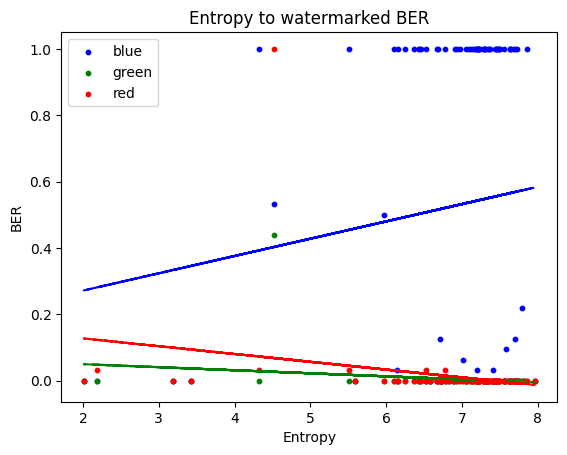

In [56]:
# plot image entropy to watermarked decoded BER, NOT ATTACKED
colors = {
    'DwtDctWatermarker': 'blue',
    'DwtDctSvdWatermarker': 'green',
    'RivaGanWatermarker': 'red'
}

entropy = []
ber = []
color_list = []
failed, total = 0, 0
for dto in data:
    for watermark in dto.watermarks:
        total += 1
        try:
            img = cv2.imread(dto.filepath)
            x = cv2.calcHist([img], [0], None, [256], [0, 256])
            x = -np.sum(x[x > 0] / np.sum(x) * np.log2(x[x > 0] / np.sum(x)))
            y = -1
            if watermark.decoding_results.decoding_metrics is None or watermark.decoding_results.decoding_metrics.Bit_Error_Rate is None:
                y = 1
            else:
                y = watermark.decoding_results.decoding_metrics.Bit_Error_Rate
            entropy.append(x)
            ber.append(y)
            color_list.append(colors[watermark.name])
        except:
            failed += 1
            pass
if failed/total > 0.1:
    print(f"Failed to load BER for {failed} attacks ({failed/total:.2%})")

fig, ax = plt.subplots()
for color in colors.values():
    indices = [i for i, c in enumerate(color_list) if c == color]
    ax.scatter([entropy[i] for i in indices], [ber[i] for i in indices], c=color, label=color, s=10)  # Set point size to 10

ax.set_title("Entropy to watermarked BER")
ax.set_xlabel("Entropy")
ax.set_ylabel("BER")
ax.legend()
# add trendline for each color
for color in colors.values():
    indices = [i for i, c in enumerate(color_list) if c == color]
    z = np.polyfit([entropy[i] for i in indices], [ber[i] for i in indices], 1)
    p = np.poly1d(z)
    plt.plot([entropy[i] for i in indices], p([entropy[i] for i in indices]), "--", c=color)
plt.show()
